# HMM

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as distance
import bidict

import literate
import HMM2 as HMM
import poet

In [2]:
syldict = literate.syldict("data/Syllable_dictionary.txt")
data, words = literate.read("data/shakespeare.txt", syldict)
rhymes = literate.get_rhymes(data)

print(len(data), "sonnets\n",
      len(words), "unique words\n",
      len(syldict), "words in dictionary\n",
      len(rhymes), "rhyming words")

154 sonnets
 3205 unique words
 3205 words in dictionary
 1015 rhyming words


In [3]:
wmap = bidict.bidict(enumerate(words)).inv

In [4]:
def toNum(wmap, words):
    return [wmap[w] for w in words]

def toWord(wmap, nums):
    return [wmap.inv[i] for i in nums]

def squash(sonnet):
    return [w for l in sonnet for w in l]

nummed = [toNum(wmap, squash(s)) for s in data]

## Training

In [5]:
nstates = [2,4,8,12,16]
hmms = []
curves = []
for n in nstates:
    print("STATES", n)
    hmm,s = HMM.unsupervised(nummed, N_iters=20, n_states=n)
    hmms.append(hmm)
    curves.append(s)
hmm = hmms[-1]

STATES 2
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 34.071141481399536
STATES 4
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 51.8531289100647
STATES 8
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 86.29310584068298
STATES 12
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 122.04205775260925
STATES 16
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 153.1505150794983


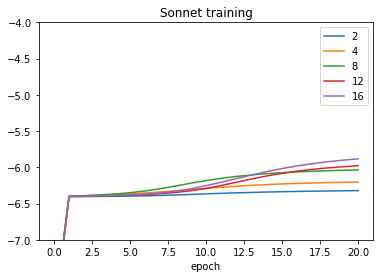

In [22]:
for i,c in zip(nstates,curves):
    plt.plot(c, label=i)
plt.ylim(-7,-4)
plt.title("Sonnet training")
plt.xlabel("epoch")
plt.legend()

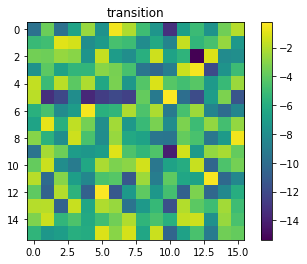

In [7]:
plt.title("transition")
plt.imshow(np.log(hmm.A))
#plt.imshow(hmm.A)
plt.colorbar()

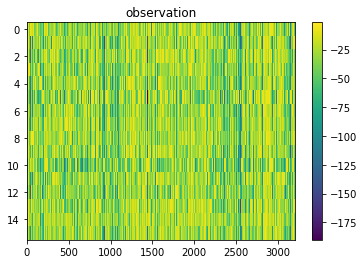

In [8]:
plt.title("observation")
plt.imshow(np.log(hmm.O), aspect='auto')
#plt.imshow(hmm.O, aspect='auto')
plt.colorbar()

In [9]:
HMM.probability_alphas(hmm, nummed[0], log=True)

-633.4858746835737

## Generation

In [10]:
# naive generation
for hmm in hmms:
    print("STATES", hmm.L)
    em, st = HMM.generate_emission(hmm, 140)
    literate.recite(poet.sonnetify(wmap, syldict, em))
    print()

STATES 2
hast what bear posterity inviting
triumphant sure his mine thou in is thine
times impediments forlorn thou to dumb
was and mayst this retention so the for
in what no making earth i kept his thy what
to strength grind good we love thine of interim
of i thee husband's spite woeful of i
bed state up art was mistress knows durst brain
word all action to gentle own i art
should your words i land gives sweetly what you
and to eye thy much unknown error now
faith thine there flesh thorns of complexion my
deformed'st too be in when burthens much will
precious thou doth vision his despite been

STATES 4
to fortune's the as not at of saw my
for my with will too be in breast refigured
come for wondrous making her though cloud the a
ages behaviour do thy be steal wane
th' groan so doctor-like angel discontent
be his youth their thou beard beauty's is blindness
of thou thy this scope the looked leave to-morrow
sail sometime vassalage thy beauty fears
not of sense night with wise want well 

In [11]:
# the remaining cells will use this hmm
hmm = hmms[-1]

In [12]:
# generate sonnet with constrained syllables and rhyme
sonnet = poet.generate_sonnet(hmm, wmap, rhymes, syldict)
literate.recite(sonnet)

view my soul even your were you now and soul
thrall disgrace write to a time of no by
who me not shadows golden wilt hence t' th' th' th' t' th' th' th' th' th' th' th' th' th'
fickle love love forbear thee it not t' th' lie
it can your which time's love that me or set
blunt physicians moan leaped unlooked your more
every and like is not as in birds th' th' th' th' th' th' th' th' debt
when day in but succeeding laid and th' store
far might never part and i mine strong excuse
general love on all blood argument i
let my this thought that take lack vow scythe th' use
and befriends excuse is some in a be
modern you hath fall me be there he now
be one thy a me least on a most th' how


## visualization

In [13]:
def top_words(wmap, hmm, n=10):
    ids = np.argsort(hmm.O, axis=1)[:,-n:]
    words = [
        [wmap.inv[w] for w in s]
        for s in ids
    ]
    return words, np.sort(hmm.O, axis=1)[:,-n:]

In [14]:
top, topprob = top_words(wmap, hmm)

In [15]:
literate.recite([[str(i)]+words for i,words in enumerate(top)])

0 look when upon can from with for of and to
1 which if me yet mine is be you i thou
2 must eye which eyes dost thou art so i it
3 have like all as on from with and in to
4 or my me and sweet this heart self thee love
5 false new am have so are time his the a
6 on all so your i by that in thy my
7 but this me her all which that him thee love
8 beauty therefore in and how from this now all to
9 self will shall for and thou but in is when
10 which but doth for o when with to and of
11 but so do no be thou me you a i
12 your with thee such me his their a i the
13 that live then i be should doth but as not
14 mine so he it for make and to in that
15 so with on in your is to i my that


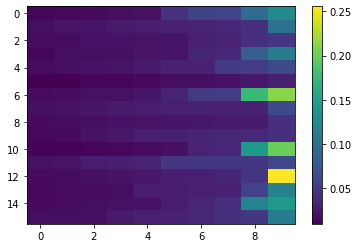

In [16]:
plt.imshow(topprob, aspect="auto")
plt.colorbar()

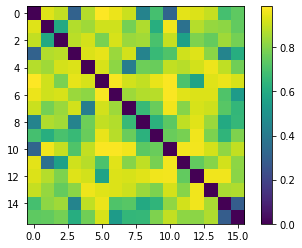

In [17]:
dists = distance.squareform(distance.pdist(hmm.O, "cosine"))
plt.imshow(dists)
plt.colorbar()

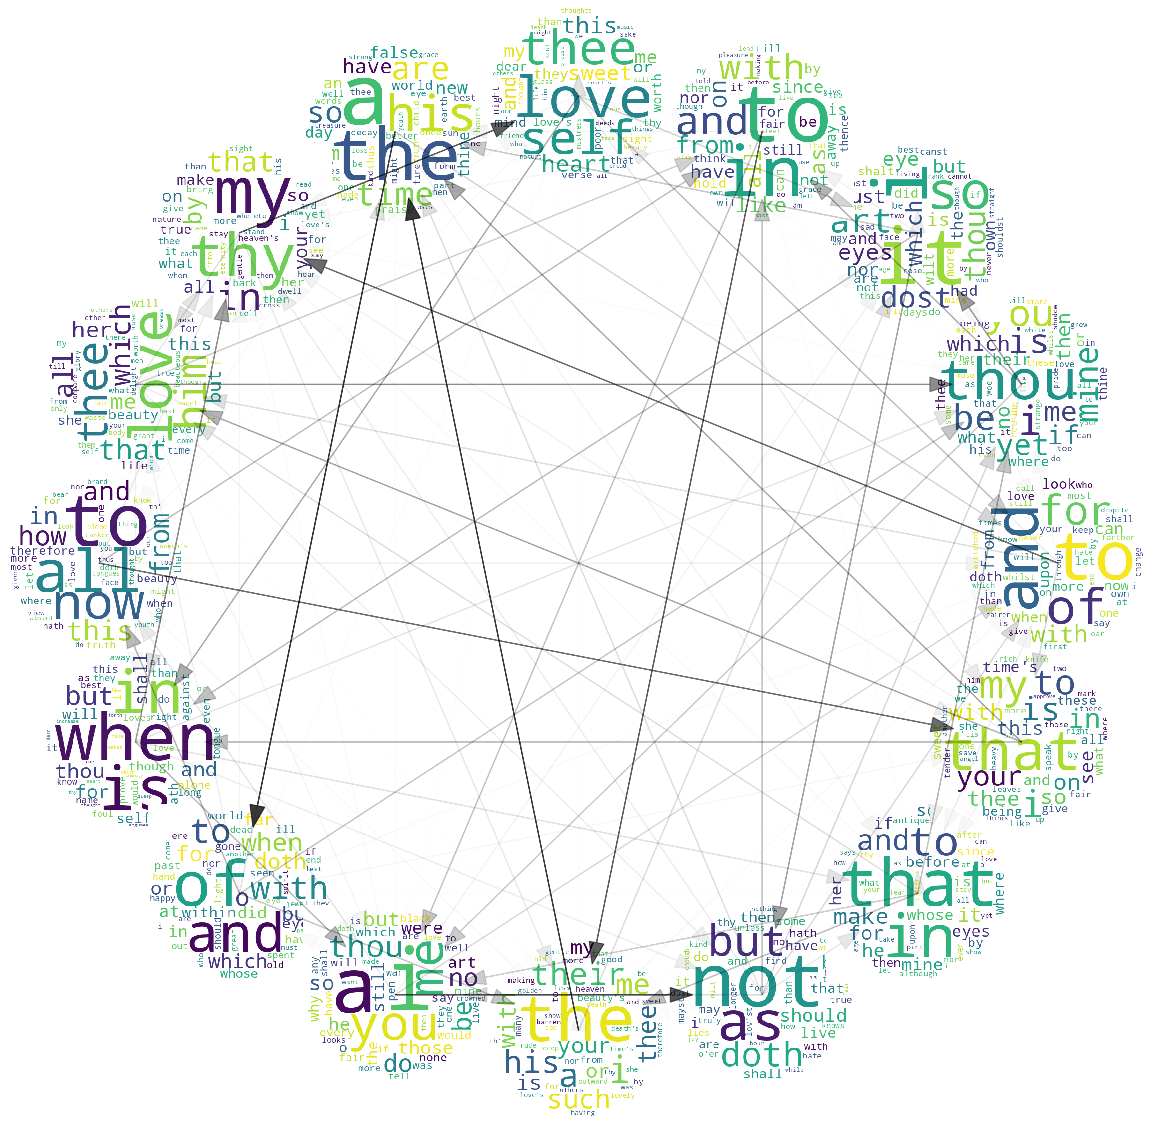

In [18]:
ax = poet.visualize_transitions(wmap, hmm, 1024, 196)